# Practicalities of AutoML forecasting

In this notebook, we will walk through the process of trying to actually push a real world dataset through AutoML. AutoML has expectations of clean data which are rarely encountered with real world data. We will show various techniques of detecting the problems before they crash AutoML, and workarounds that will get you through the day.

Eventually, these tips and tricks will become part of the AutoML product, prettied up and made more robust.

Many of the cells in this notebook will show the first attempt at doing something, which is later abandoned or cleaned up. They are marked with `DEAD END`. Don't run them, they are there so that you can learn from my mistakes, not your.

To begin, let's load some data. Our first dead end occurs in the data loading, and is shown in the companion notebook `GetDataFromSQL`. But for now, _assume_ we have the data.

In [1]:
import pandas

SQLdata = pandas.read_csv('data/tutorial_data.csv.bz2')
SQLdata.describe(include = 'all')

# depending on the size your machine, you might want to filter down further to get through the notebook
# uncomment this filter
SQLdata = SQLdata[SQLdata['Site'] == '1B3B']
SQLdata.shape

(139450, 5)

The data is a friendly 1.2M rows, which is because it only contains the 348 items beginning with 'A'.

In [2]:
SQLdata['Item'].drop_duplicates()

0          A00968
377        A010AB
10431      A01370
10463      A02987
10798      A04A18
16583      A05356
18806      A05794
22241      A0627A
29702      A0802D
32341      A094CE
71098      A0BC16
79469      A0CA5B
81591      A0CD71
84503      A0E454
86827      A101A5
95092      A111EE
95475      A14155
101354     A14FAE
101592     A16215
115800     A16F1A
115827     A17D12
120900     A1B8E9
132433     A1C7BB
145727     A1F65A
179355     A1F866
179850     A20757
181596     A213F3
192118     A22A9A
192580     A23BD3
195774     A2615A
            ...  
1036091    AD20C9
1036522    AD41E5
1038913    AD4B2F
1058380    AD7174
1059772    AD849C
1060873    AD9631
1071111    ADC402
1077082    AE1C07
1079363    AE4C10
1093124    AE6D5B
1093802    AE79B6
1093859    AE7C41
1101168    AE8349
1103242    AE92B6
1103813    AEA5F7
1104110    AEBBB7
1106332    AEC7F3
1107898    AEDF2A
1108399    AEF12C
1109893    AF387A
1139718    AF3B02
1147928    AF56E5
1148442    AF59E4
1149505    AF7676
1150516   

Now we'll establish the time series metadata. These say: we want to forecast the Quantity, along the time axis given by SalesDate, for each combination of Item, Site, and Channel.

In [3]:
grain_colnames = ['Item', 'Site', 'Channel']
time_colname = 'SalesDate'
target_colname = 'Quantity'

In [4]:
# How many series do we have?
guppy = SQLdata.groupby(grain_colnames)

print("Rows pulled : " + str(len(SQLdata)))
print("Distinct time series : " + str(len(guppy)))

Rows pulled : 139450
Distinct time series : 565


# Let's forecast!

AutoML in theory does not need much more than a data frame. So let's see how far AutoML gets on this **tough** dataset. Let us not even split into train and test (because we may need to re-work the data).

In [5]:
X_train = SQLdata.copy()
y_train = X_train.pop(target_colname).values

Begin our forecasting journey with the boilerplate AutoML imports and connections.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import warnings
import os
# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

import azureml.core
from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
ws = Workspace.from_config()

# choose a name for the experiment in the workspace
# 'Experiment' roughly corresponds to a 'problem to solve'
experiment_name = 'automl-grocery'
# where to write models and other artifacts locally
project_folder = './sample_projects/automl-grocery'
experiment = Experiment(ws, experiment_name)

WARNING - Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [6]:
output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.41
Subscription ID,938fa533-eeb9-4121-b97f-05b31c6eb088
Workspace,automl-customers
Resource Group,automl
Location,westus2
Project Directory,./sample_projects/automl-grocery
Run History Name,automl-grocery


Now, we specify what our forecasting problem is, put the spec in the config object form, and run it.

In [8]:
time_series_settings = {
    'time_column_name': time_colname,
    'grain_column_names': grain_colnames,
    'drop_column_names': [],
    'max_horizon': 31
}

automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl-grocery.log',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations=5,
                             X=X_train,
                             y=y_train,                             
                             n_cross_validations=2,
                             enable_ensembling=False,
                             path=project_folder,
                             verbosity=logging.INFO,    
                             **time_series_settings)

local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_e19a9666-28f0-4f22-a05a-63d90362950c
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:04       0.0096  

The errors are expected: our dataset has many intermittent series. For example, look at this series, focusing on the `SalesDate` column. Could *you* determine what its natural reporting frequency is?

In [10]:
SQLdata[(SQLdata['Item'] == 'A0CA5B') & (SQLdata['Site'] == '1B3B') & (SQLdata['Channel'] == '811B')]

,SalesDate,Item,Site,Channel,Quantity
79490,2012-01-24,A0CA5B,1B3B,811B,4.00
79491,2012-01-30,A0CA5B,1B3B,811B,9.00
79492,2012-02-02,A0CA5B,1B3B,811B,4.00
79493,2012-02-04,A0CA5B,1B3B,811B,3.00
79494,2012-02-17,A0CA5B,1B3B,811B,5.00
79495,2012-02-29,A0CA5B,1B3B,811B,4.00
79496,2012-03-07,A0CA5B,1B3B,811B,4.00
79497,2012-03-10,A0CA5B,1B3B,811B,7.00
79498,2012-03-14,A0CA5B,1B3B,811B,5.00
79499,2012-03-23,A0CA5B,1B3B,811B,5.00


# Technique 1: Filling in the implicit zeros

Let's help AutoML determine what the periodicity is by making the series explicitly daily. Since we are talking about sales, missing values correspond to zero quantity sold.

In [11]:
# We have a nice helpful function that fills out the data frame with:
# * zeros for the target column
# * NaNs for the rest of the data
# 
# Let's import it from out time series library in the repo.
from tslib.ts_functions import fill_out_with_zeros

In [12]:
# since frequency is hard to infer with intermittent data, we will tell the function explicitly
# the frequency is daily
complete = fill_out_with_zeros(SQLdata, time_colname, grain_colnames, target_colname, 'D')
complete.shape

Got 139450 values NOT including zeros
Expecting 621150 values including zeros
Check these match... otherwise bad things happen to merge.
['Item: object', 'Site: object', 'Channel: object', 'SalesDate: datetime64[ns]']
['Item: object', 'Site: object', 'Channel: object', 'SalesDate: datetime64[ns]']


(621150, 1)

Note the data engorged to 6M rows - all the days with no record now have explicit 0 sales. We call that a "flat" dataframe.

In [13]:
# the data comes out with the grain and time in a pandas MultiIndex
flat_complete = complete.reset_index()
flat_complete.to_csv("grocery_flat.csv.bz2", compression='bz2', index=False)

In [14]:
# how do I split the data? It's about 5 years of data, 2012-01-01 to 2017-08-31.
# It probably does not make sense to do more than one month ahead of daily predictions
n_test_periods = 31 # days in August 2017

# this will split off the last n VALUES from each grain. If the data has implicit zeros,
# that means the test TIME INTERVAL may vary by grain.
from tslib.ts_functions import split_last_n_by_grain

# Do note the use of the parameter specifying the minimum grain length.
# Because of how we pulled the data from SQL, the use is redundant.
# But if your whole data fits in memory, you can filter out the short grains
# in python, rather than at the source, using the splitting function
df_train, df_test = split_last_n_by_grain(complete, 
                                          n_test_periods, 
                                          time_colname, grain_colnames, 
                                          min_grain_length=100)

In [15]:
print(df_train.shape)
print(df_test.shape)

(603635, 1)
(17515, 1)


We know how many datapoints we have. But do we really know where the train and test sets are situated in time?
Let's look at their time extents. For ease of plotting, only two items (but with all their Site and Channel combinations) will be shown.

(1049, 1)
(62, 1)


<IPython.core.display.Javascript object>


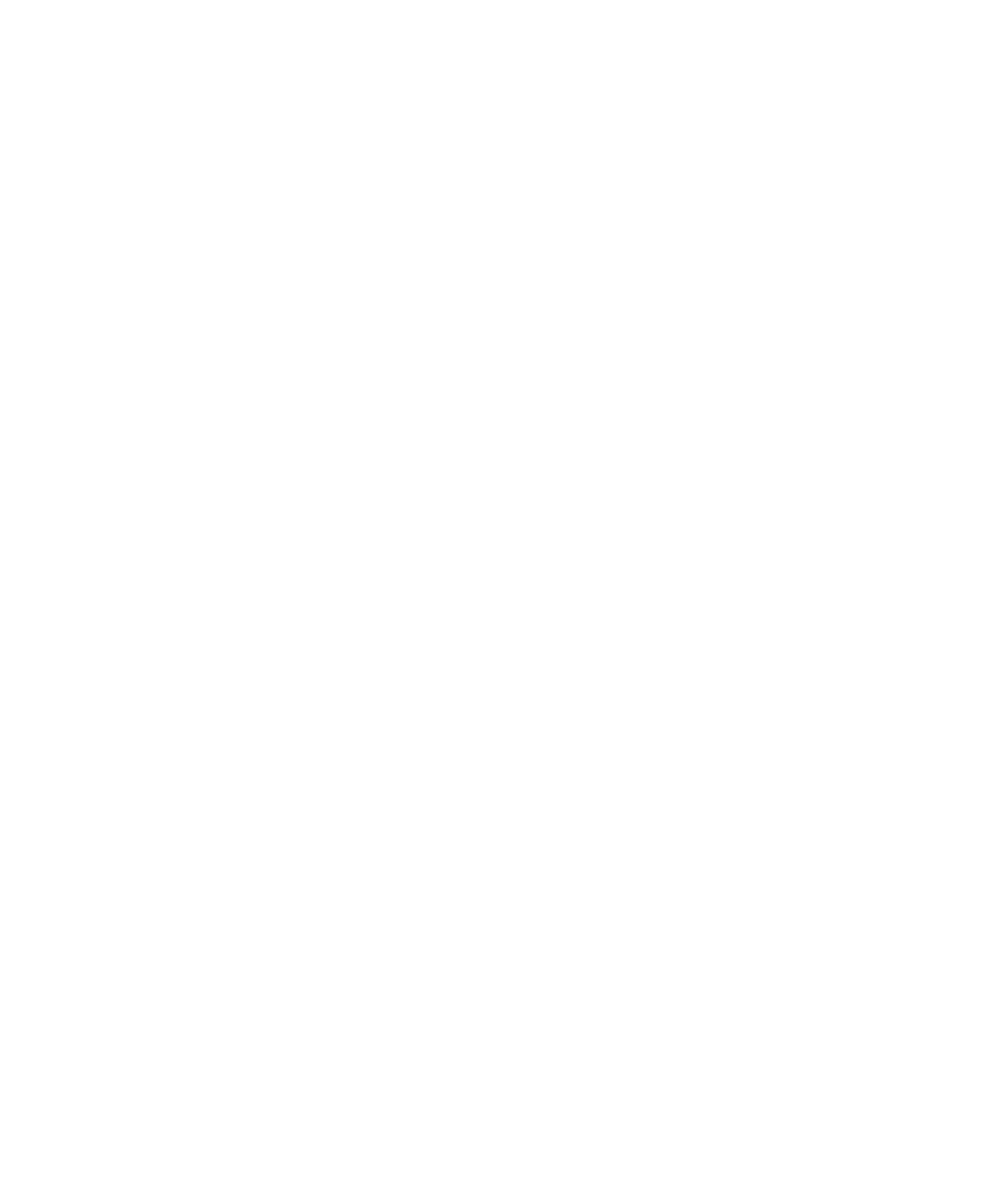

In [16]:
smaller = complete.loc[(['A00968', 'A09D61'], slice(None), slice(None), slice(None)), :]
small_train, small_test = split_last_n_by_grain(smaller, n_test_periods, time_colname, grain_colnames, min_grain_length=100)
print(small_train.shape)
print(small_test.shape)

# this is for checking the time extent of the grains
ranges_train = small_train.reset_index().groupby(grain_colnames).agg({'SalesDate': ['min', 'max']})
ranges_train.columns = ['begin', 'end']
ranges_train_flat = ranges_train.reset_index()

ranges_test = small_test.reset_index().groupby(grain_colnames).agg({'SalesDate': ['min', 'max']})
ranges_test.columns = ['begin', 'end']
ranges_test_flat = ranges_test.reset_index()

# we should be able to plot that
%matplotlib notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 12]
import matplotlib.pyplot as plt

plt.hlines(range(len(ranges_train_flat)),xmin=ranges_train_flat['begin'].values,xmax=ranges_train_flat['end'].values)
plt.hlines(range(len(ranges_test_flat)),xmin=ranges_test_flat['begin'].values,xmax=ranges_test_flat['end'].values, colors='r')
ytick_tuples = list(zip(ranges_train_flat['Item'],ranges_train_flat['Site'], ranges_train_flat['Channel']))
ytick_labels = list(map(lambda t : '-'.join(t), ytick_tuples))
plt.yticks(range(len(ranges_test_flat)), ytick_labels)
plt.show()

# Improvements on this plot could include 
#    * plot little series instead of horizontal lines, 
#    * color-separating zero values


We should ask ourselves whether the items whose histories do not reach the temporal end of the dataset are worth forecasting. Those items may have been discontinued, or they are still carried by the store but purchased infrequently. Since that is a question only a business owner can answer, let's leave them in for now. But have that little practicality in mind.

Let's save the dataset we have in case we need to restart from this point.

In [17]:
# Checkpoint: flatten for writing and save
flat_test = df_test.reset_index()
flat_test.to_csv("grocery_flat_test.csv.bz2", compression='bz2', index=False)

In [18]:
flat_train = df_train.reset_index()
flat_train.to_csv("grocery_flat_trainvalid.csv.bz2", compression='bz2', index=False)

In [19]:
# redefine what X and Y are - now with the zeros
X_train = flat_train
X_test = flat_test
y_train = X_train.pop(target_colname).values
y_test = X_test.pop(target_colname).values

This will take some time to finish with 6M rows.

In [20]:
automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl-grocery.log',
                             primary_metric='r2_score',
                             iterations=5,
                             X=X_train,   # Here the X_train and y_train have
                             y=y_train,   # explicit zeroes                             
                             n_cross_validations=2,
                             enable_ensembling=False,
                             path=project_folder,
                             verbosity=logging.INFO,    
                             **time_series_settings)

local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_b5ed0906-934e-4073-95b5-23a2a8256190
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper LightGBM                 0:01:42       0.1435  

Note we are not testing here because we pretend AutoML had a memory error. The data we are using in the tutorial may not actually be too large as we are only using items beginning with 'A'. But with the full dataset, the AutoML run in the above cell did fail.

# Technique 2: Splitting the datasets and composite models

## (NOT your usual train/test splitting)

In [1]:
# Checkpoint: restarting the processing from saved files
# A good practice if you work with dataset sizes that crash python kernels
grain_colnames = ['Item', 'Site', 'Channel']
time_colname = 'SalesDate'
target_colname = 'Quantity'

import pandas as pd
flat_train = pd.read_csv("grocery_flat_trainvalid.csv.bz2", compression='bz2', parse_dates=[time_colname])
flat_test = pd.read_csv("grocery_flat_test.csv.bz2", compression='bz2', parse_dates=[time_colname])

We arrived at this point because AutoML had an out-of-memory event. 

If the data is too large, we need to split the series into multiple chunks to be handled separately. The data amounts in the individual chunks should ideally be close to equal.

It is best to split by the value of a specified column. It should be one of the grain columns - that way grains are guaranteed not to split across bins. 

'Item' seems like a good candidate column. How variable do the Item-based groups get in size?

In [3]:
flat_train.groupby('Item').size()

Item
A00968     1049
A010AB     1020
A01370      556
A02987      919
A04A18     5118
A05356      271
A05794     3819
A0627A     1524
A0802D      265
A094CE    10173
A0BC16      860
A0CA5B      527
A0CD71     4552
A0E454      401
A101A5    10124
A111EE      176
A14155     9725
A14FAE     1035
A16215     9532
A16F1A     2187
A17D12     2543
A1B8E9     6660
A1C7BB     3157
A1F65A    10018
A1F866      820
A20757      554
A213F3    10109
A22A9A      368
A23BD3     4514
A2615A     1296
          ...  
AD20C9      124
AD41E5      596
AD4B2F     8143
AD7174      586
AD849C       99
AD9631     9369
ADC402      423
AE1C07       72
AE4C10     8171
AE6D5B      155
AE79B6      955
AE7C41     5287
AE8349     2165
AE92B6      794
AEA5F7      733
AEBBB7     1444
AEC7F3     2714
AEDF2A       83
AEF12C       94
AF387A    10449
AF3B02     6878
AF56E5      123
AF59E4      305
AF7676      448
AF8A0C     9941
AF9EAB       91
AF9FF9     9230
AFB98C     2994
AFCB88    10187
AFE443    10000
Length: 172, dtype:

We see the size is quite variable. Randomly assigning each item to a subset (chunk) would likely achieve approximately even chunks if the Items were about equal in data size, but we see the variation spans orders of magnitudes.

Therefore, after grouping by column value, then approximately solve the bin packing problem with maximum volume equal to the max number of rows we are willing to have for one model. This will guarantee near-optimal packing.  

In [2]:
from tslib.ts_functions import split_into_chunks_by_size, split_into_chunks_by_groups
    
max_number_of_rows = 100 * 1000;
train_frames, indices = split_into_chunks_by_size(flat_train, 'Item', max_number_of_rows)

# split test set using the same assignment of item to chunk (indices)
test_frames = split_into_chunks_by_groups(flat_test, 'Item', indices)

In [24]:
# Checkpointing: pickle the split datasets
import pickle
pickle.dump( (train_frames, test_frames, indices), open('split_datasets.pkl', 'wb'))

In [25]:
# and load them back after the lengthy procedure
import pickle
(train_frames, test_frames, indices) = pickle.load(open('split_datasets.pkl', 'rb'))

grain_colnames = ['Item', 'Site', 'Channel']
time_colname = 'SalesDate'
target_colname = 'Quantity'

Let's ensure we got decently sized chunks. Each chunk is a separate dataset that we will feed into AutoML.

In [3]:
idx = 0
model_valid_for = indices[idx]
X_train = train_frames[idx].copy()
X_test = test_frames[idx].copy()

y_train = X_train.pop(target_colname).values
y_test = X_test.pop(target_colname).values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(99977, 4)
(1581, 4)
(99977,)
(1581,)


We see that the first chunk has the expected size for the train and test dataset. Let's test whether we messed up the datasets in the process of splitting. Running it through AutoML will run the data checks.

In [7]:
time_series_settings = {
    'time_column_name': time_colname,
    'grain_column_names': grain_colnames,
    'drop_column_names': [],
    'max_horizon': 31
}

automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl-grocery.log',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations=5,
                             X=X_train,   # set the train to the NEW train set
                             y=y_train,   # which is now the first chunk only                      
                             n_cross_validations=2,
                             enable_ensembling=False,
                             path=project_folder,
                             verbosity=logging.INFO,    
                             **time_series_settings)

local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_937dd8dc-d56b-4a6f-ad6d-144b172ccdc8
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:05       0.0096  

In [8]:
best_run, fitted_pipeline = local_run.get_output()
fitted_pipeline.steps
y_query = y_test.copy()
y_query.fill(np.nan)
y_fcst, X_trans = fitted_pipeline.forecast(X_test, y_query)   

In [9]:
from tslib.ts_functions import align_outputs
df_all = align_outputs(y_fcst, X_trans, X_test, y_test, target_colname)

That worked! Now that we were able to get a model, let's import the preferred and customary forecasting metrics and see how well we are doing.

In [10]:
from tslib.ts_functions import MAPE, SMAPE, MAE

rmse = np.sqrt(mean_squared_error(df_all[target_colname], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_all[target_colname], df_all['predicted'])
print('mean_absolute_error score: %.2f' % mae)
mape = MAPE(df_all[target_colname], df_all['predicted'])
print('MAPE: %.2f' % mape)
smape = SMAPE(df_all[target_colname], df_all['predicted'])
print('SMAPE: %.2f' % smape)
mae = MAE(df_all[target_colname], df_all['predicted'])
print('MAE: %.2f' % mae)

[Test Data] 
Root Mean squared error: 8.86
mean_absolute_error score: 5.50
MAPE: 68.15
SMAPE: 87.71
MAE: 549.87


The MAPE, and even SMAPE metrics can be deceiving when dealing with time series that are often close to zero. They divide by small values and are quite volatile. This makes them a poor fit for such problems. 

MAE is a better metric for these cases because it avoids division. But be careful because MAE results are unnormalized and comparing them only makes sense in reference to a fixed test set. MAE places weight on series whose absolute value is large. This is often correct in business. Mis-forecasting the Microsoft intern program travel expenses is a lot smaller deal than mis-forecasting the Azure datacenter operations cost. Series trained towards MAE should be of similar magnitude. 

It is often helpful to stratify the series by the `ceil(log(mean(series)))` and train separate models which allows for more homogeneous training set magnitude-wise and will lead to better performance on smaller-magnitude series.

But the best way to get a sense of how well a classifier is performing is to just plot the forecasts vs actuals. The mini-library has some plotting functions for you.

In [28]:
def plot_forecast(X_trainval, y_trainval,
                  X_test, y_test, y_pred,
                  target_column_name,
                  time_column_name,
                  grain_column_names,
                  actual_color='blue',
                  pred_color='green',
                  filter_dict = None):
    """
    Plot a forecast.
    
    Params:
        filter_dict: a mapping from column to list of values
                     Will be used to filter data down. Only rows
                     that contain the listed values for column will be retained.                     
    """
    
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    test_set = X_test.copy()
    test_set[target_column_name] = y_test
    test_set['prediction'] = y_pred
    
    train_set = X_trainval.copy()
    train_set[target_column_name] = y_trainval
    train_set['prediction_lower95'] = y_trainval
    train_set['prediction_upper95'] = y_trainval
    train_set['prediction_lower50'] = y_trainval
    train_set['prediction_upper50'] = y_trainval

    if filter_dict is not None:
        for col, values in filter_dict.items():
            if not isinstance(values, list):
                values = [ values ]            
            train_set = train_set[ train_set[col].isin(values)]
            test_set = test_set[ test_set[col].isin(values)]            
    
    rmse = np.sqrt(mean_squared_error(test_set[target_column_name], test_set['prediction']))
    test_set['prediction_lower95'] = test_set['prediction'] - 1.96 * rmse
    test_set['prediction_upper95'] = test_set['prediction'] + 1.96 * rmse
    test_set['prediction_lower50'] = test_set['prediction'] - 0.67 * rmse
    test_set['prediction_upper50'] = test_set['prediction'] + 0.67 * rmse
    
    train_set.sort_values(time_column_name, inplace=True)
    test_set.sort_values(time_column_name, inplace=True)
    
    # filter the train set to the same length as test set to avoid squished plot    
    _ , train_set = split_last_n_by_grain(train_set, 2*len(test_set), time_column_name, grain_column_names)
    
    plt.plot(train_set[time_column_name], train_set[target_column_name], c=actual_color)   # train-period actuals
    plt.plot(test_set[time_column_name], test_set[target_column_name], c=actual_color)     # test-period actuals
    plt.plot(test_set[time_column_name], test_set['prediction'], c=pred_color)  # test-period predictions
    plt.fill_between(test_set[time_column_name].values,                      # test-period confidence interval
                 test_set['prediction_lower95'].values, # workaround for matplotlib cannot handle datetime64s
                 test_set['prediction_upper95'].values, 
                 color=pred_color, alpha=.1)
    
    plt.fill_between(test_set[time_column_name].values,                      # test-period confidence interval
                 test_set['prediction_lower50'].values, # workaround for matplotlib cannot handle datetime64s
                 test_set['prediction_upper50'].values, 
                 color=pred_color, alpha=.2)
    
    # plt.xticks(rotation=60)
    plt.legend(['Actual (train)', 'Actual (test)', 'Prediction', '95% Confidence', '50% Confidence'], 
               loc="upper left",
               fontsize='x-large')
    plt.title(' and '.join(filter_dict.values()))
    
    plt.show()
    return train_set, test_set


In [19]:
X_train[ X_train['Item'] =='A01370'].head()

,Item,Site,Channel,SalesDate


In [22]:
X_train.groupby(['Item']).count()

,Site,Channel,SalesDate
Item,,,
A094CE,10173,10173,10173
A101A5,10124,10124,10124
A213F3,10109,10109,10109
A2FEBF,10127,10127,10127
A53634,10913,10913,10913
A63B66,7621,7621,7621
A68158,10172,10172,10172
A7114D,10102,10102,10102
AF387A,10449,10449,10449


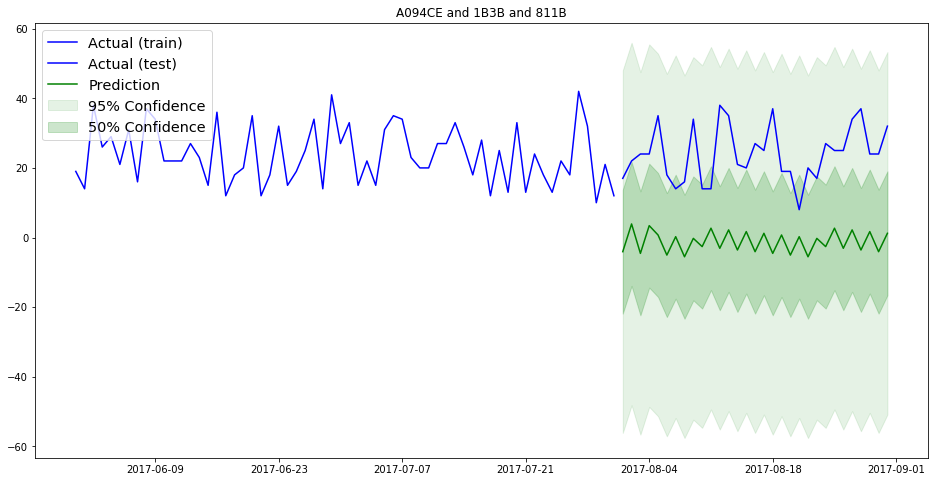

(         Item  Site Channel  SalesDate  Quantity  prediction_lower95  \
 22616  A094CE  1B3B  811B   2017-05-31 19.00     19.00                 
 22617  A094CE  1B3B  811B   2017-06-01 14.00     14.00                 
 22618  A094CE  1B3B  811B   2017-06-02 38.00     38.00                 
 22619  A094CE  1B3B  811B   2017-06-03 26.00     26.00                 
 22620  A094CE  1B3B  811B   2017-06-04 29.00     29.00                 
 22621  A094CE  1B3B  811B   2017-06-05 21.00     21.00                 
 22622  A094CE  1B3B  811B   2017-06-06 31.00     31.00                 
 22623  A094CE  1B3B  811B   2017-06-07 16.00     16.00                 
 22624  A094CE  1B3B  811B   2017-06-08 37.00     37.00                 
 22625  A094CE  1B3B  811B   2017-06-09 34.00     34.00                 
 22626  A094CE  1B3B  811B   2017-06-10 22.00     22.00                 
 22627  A094CE  1B3B  811B   2017-06-11 22.00     22.00                 
 22628  A094CE  1B3B  811B   2017-06-12 22.00     2

In [11]:
# Let's do a time series plot for our difficult intermittent series
from tslib.ts_plot_utils import plot_forecast, jupyter_matplotlib_magic


#def plot_forecast(X_trainval, y_trainval,
#                  X_test, y_test, y_pred,
#                  target_column_name,
#                  time_column_name,
#                  actual_color='blue',
#                  pred_color='green',
#                  filter_dict = None)

filt = {'Item' : 'A094CE',
        'Site' : '1B3B',
        'Channel' : '811B' }

jupyter_matplotlib_magic()

plot_forecast(X_train, y_train, X_test, y_test, y_fcst,
                  target_colname, time_colname, grain_colnames,
                  filter_dict = filt)

<IPython.core.display.Javascript object>


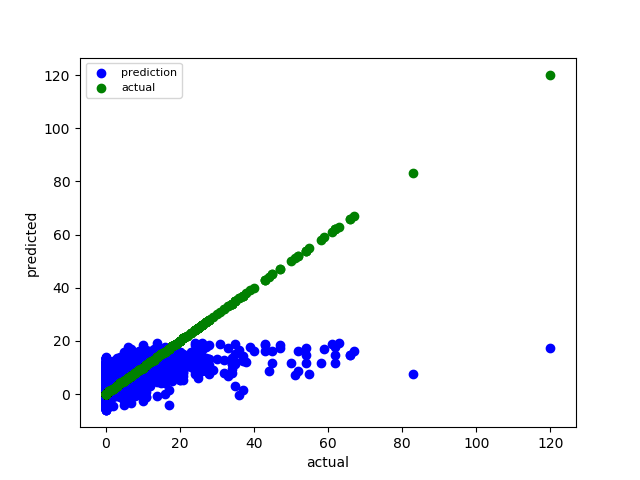

In [14]:
# Let's do a scatter plot of actual vs predicted

%matplotlib notebook
test_pred = plt.scatter(df_all[target_colname], df_all['predicted'], color='b')
test_actl = plt.scatter(df_all[target_colname], df_all[target_colname], color='g')
plt.legend((test_pred, test_actl), ('prediction', 'actual'), loc='upper left', fontsize=8)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

This underprediction of higher demands would make a good case for stratification or adding lags, but let's complete the exercise and return to the problem later.

### Putting the models back together

We split the data into small enough chunks that we can learn a model from each. But this is mildly inconvenient - we now have a collection of models and each of them can only process a subset of the data. We need to keep track of which models serves which `Item`s. To do this without writing awkward code on your side, we offer the general technique of *composite models*.

In the forecasting case, we usually have a natural splitting column in the grain. It would be extraordinary to have a single time series (no grain) big enough to require this treatment.

In the more general case of classification or regression, no good categorical splitting column may exist in the data. You can still split the data, and all the models you learn will be "universal" - capable of classifying any instance. You will lose some predictive power, because you learned from smaller datasets. But you can get it back by running the example through `predict()` of *all* the models and ensembling the predictions (just take a simple majority vote or average).


In [32]:
class CompositeModel:    
    
    def __init__(self, split_column, target_column):
        self._split_column = split_column
        self._target_column = target_column
        self._item_run_map = dict()
        self._item_model_map = dict()
        self._model_impls = dict()
        self._indices = dict()
    

    # todo: redo this so that this class splits its own training data
    # on the splitcolumn, ideally in sequence, rather than materializing
    # the whole dataset again in memory as a sequence of chunks. 
    
    def fit(self, train_frames, indices):    
        
        self._indices = indices
            
        # TODO: this is hard-wired and overwrites outer scope        
        time_series_settings = {
            'time_column_name': time_colname,
            'grain_column_names': grain_colnames,
            'drop_column_names': [],
            'max_horizon': 31
        }
        
        for idx, Xy in enumerate(train_frames):
            
            if len(Xy) == 0:
                print('Warning: found a zero-length frame at index ' + str(idx))
                continue
            
            X_train = Xy.copy()            
            y_train = X_train.pop(self._target_column).values                        
          
            automl_config = AutoMLConfig(task='forecasting',
                                debug_log='automl-grocery.log',
                                primary_metric='normalized_root_mean_squared_error',
                                iterations=5,
                                X=X_train,
                                y=y_train,                             
                                n_cross_validations=3,
                                enable_ensembling=False,
                                path=project_folder,
                                verbosity=logging.INFO,    
                                **time_series_settings)
        
            # get the model and metadata
            local_run = experiment.submit(automl_config, show_output=True) # Parent run 
            best_run, fitted_pipeline = local_run.get_output()             # Favorite child
            model_id = best_run.id
            print('Learned model ' + str(model_id))  # this is not working - needs a different ID
        
            # record the model for item
            self._model_impls[model_id] = fitted_pipeline
            for idx, item in enumerate(self._indices[idx]):
                self._item_model_map[item] = model_id
                self._item_run_map[item] = best_run.id
                
                
    def forecast(self, X_test, y_test):
        
        # split X and y together by splitcolumn
        X_copy = X_test.copy()
        X_copy['__automl_target_column'] = y_test
        chunks = split_into_chunks_by_groups(X_copy, self._split_column, self._indices)
        
        ys = []
        X_transes = []
        for chunk in chunks:
            
            # skip potentially empty splits
            if len(chunk) == 0:
                continue
            
            # Look up the right model. It should be the same model 
            # for the whole chunk by construction
            item = chunk.loc[chunk.index[0], self._split_column]
            modelid = self._item_model_map[item]
            print('Using model ' + str(modelid))
            model = self._model_impls[modelid]
            
            paranoid = True
            if paranoid:
                for item2 in pd.unique(chunk[self._split_column]):
                    assert(
                           (item2 in self._item_model_map.keys()) and 
                           (self._item_model_map[item2] == modelid),
                           'Item ' + str(item2) + ' is not mapped to the same model ' + str(modelid) + ' as ' + str(item)
                    )
                           
            y_chunk = chunk.pop('__automl_target_column').values
            y_pred, X_trans = model.forecast(chunk, y_chunk)
            ys.append(y_pred)
            X_transes.append(X_trans)
            
        return np.concatenate(ys), pd.concat(X_transes)                    

In [ ]:
cm = CompositeModel(split_column = 'Item', target_column = 'Quantity')
cm.fit(train_frames, indices)

Running on local machine
Parent Run ID: AutoML_c9ef5712-5adc-460e-902f-ce75b1a715b1
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.


In [ ]:
# test the forecasts on one test dataframe
X_test0 = test_frames[0].copy()
y_test0 = X_test0.pop(target_colname).values
y_test0.fill(np.nan)
r0, X_trans0 = cm.forecast(X_test0, y_test0)

In [29]:
r0

(array([nan, nan, nan, ..., nan, nan, nan]),
                                 year  half  quarter  month  day  wday  qday  \
 SalesDate  Item   Site Channel                                                
 2014-09-17 AF387A 1B3B 261E     2014  2     3        9      17   2     79     
 2014-09-18 AF387A 1B3B 261E     2014  2     3        9      18   3     80     
 2014-09-19 AF387A 1B3B 261E     2014  2     3        9      19   4     81     
 2014-09-20 AF387A 1B3B 261E     2014  2     3        9      20   5     82     
 2014-09-21 AF387A 1B3B 261E     2014  2     3        9      21   6     83     
 2014-09-22 AF387A 1B3B 261E     2014  2     3        9      22   0     84     
 2014-09-23 AF387A 1B3B 261E     2014  2     3        9      23   1     85     
 2014-09-24 AF387A 1B3B 261E     2014  2     3        9      24   2     86     
 2014-09-25 AF387A 1B3B 261E     2014  2     3        9      25   3     87     
 2014-09-26 AF387A 1B3B 261E     2014  2     3        9      26   4     88 

In [18]:
# Create the full test set, actuals, and query

# OK to copy the smaller test frames
ys = [ X[target_colname].values for X in test_frames ]
Xs = [ X.copy().drop(columns=[target_colname]) for X in test_frames]
X_test = pd.concat(Xs)
y_test = np.concatenate(ys)
y_query = y_test.copy()
y_query.fill(np.nan)

In [ ]:
# test on all chunks
y_fcst, X_trans = cm.forecast(X_test,y_query)
df_all = align_outputs(y_fcst, X_trans, X_test, y_test, target_colname)
df_all.head()

In [ ]:
rmse = np.sqrt(mean_squared_error(df_all[target_colname], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_all[target_colname], df_all['predicted'])
print('mean_absolute_error score: %.2f' % mae)
mape = MAPE(df_all[target_colname], df_all['predicted'])
print('MAPE: %.2f' % mape)
smape = SMAPE(df_all[target_colname], df_all['predicted'])
print('SMAPE: %.2f' % smape)

# Technique 3: Target transforms

This dataset is extremely challenging due to the abundance of zero values. Also, the forecasts sometimes venture below zero, which will not make sense to business customers. In those cases, it often helps to transform the target value with something like a log-transform.

In [ ]:
import math

def log_transform(nparr):
    return nparr.apply(lambda x: math.log(x+1))
    

def log_inverse_transform(nparr):
    """
    With zero truncation so not a perfect inverse
    """
    return nparr.apply(lambda y: max(0, math.exp(y) - 1))
    
# For example, 
log_inverse_transform(log_transform(y_train[0:5]))

In [ ]:
idx = 0
model_valid_for = indices[idx]
X_train = train_frames[idx].copy()
X_test = test_frames[idx].copy()

# NOTE log transform
y_train = log_transform(X_train.pop(target_colname).values)
y_test = X_test.pop(target_colname).values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl-grocery.log',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations=5,
                             X=X_train,
                             y=y_train,                             
                             n_cross_validations=2,
                             enable_ensembling=False,
                             path=project_folder,
                             verbosity=logging.INFO,    
                             **time_series_settings)

local_run = experiment.submit(automl_config, show_output=True)

In [ ]:
best_run, fitted_pipeline = local_run.get_output()
fitted_pipeline.steps
y_query = y_test.copy()
y_query.fill(np.nan)
y_fcst, X_trans = fitted_pipeline.forecast(X_test, y_query)   

In [ ]:
filt = {'Item' : 'A0CA5B',
        'Site' : '1B3B',
        'Channel' : '811B' }

# TESTME: do we need to plot from the aligned data frame?
plot_forecast(X_train, y_train, X_test, y_test, 
                  inverse_log_transform(y_fcst),       # NOTE inverse transform
                  target_colname,
                  time_colname,
                  filter_dict = filt)

# Caveat 4: A note on pandas indexes

One problem that often occurs with dataframes arising from filtering is that *level names* are retained in the index when the values are *removed*. This can create empty groups when grouping by index. 

In [17]:
# This problem is pandas version dependent 
print(pd.__version__)

ex_df = pd.DataFrame({'Item' : ['A', 'A', 'B', 'B', 'C'], 
                       'Day' : ['Mon', 'Tue', 'Mon', 'Tue', 'Mon'],
                       'Sales' : [1, 2, 3, 4, 5]})
ex_df['Item'] = ex_df['Item'].astype('category')
ex_df = ex_df[ex_df['Day'] == 'Tue']  # filter down to Tue, leaving out 'C'
ex_df.groupby(['Item']).sum()

0.23.4


,Sales
Item,
A,2
B,4
C,0


Note the zero for item 'C'. This comes from an empty group.

In [19]:
# the easiest fix is to rebuild the dataframe from csv
ex_df.reset_index().to_csv('temp_ex_df.csv', index=False)
ex_df2 = pd.read_csv('temp_ex_df.csv')

# or use StringIO if you having multiple data copies in memory is acceptable
ex_df2.groupby(['Item']).sum()

,index,Sales
Item,,
A,1,2
B,3,4


This causes hard-to-understand errors, so let's make sure it didn't happen to us, checking ALL the data chunks.

In [20]:
# check for empty levels

def empty_grains(df, grain_colnames):
    """"
    returns the list of empty grains
    """
    empties = df.groupby(grain_colnames).filter(lambda g: len(g) == 0)
    return empties

frames_with_empties = [empty_grains(df, grain_colnames).shape[0] > 0 for df in train_frames]

In [21]:
any(frames_with_empties)

False

Note: This is *different* from checking whether some of the training data frames are actually empty. That would look like:

In [22]:
# check for empty dataframes in train_frames
[idx for idx, df in enumerate(train_frames) if len(df)==0]

[]

# Conclusions: What is missing here?

This exercise does not address a few things. But you are now equipped to build them on your own.
* Deployment of composite models
 * The deployment procedure will need to register all the models in the dictionary.
 * The indices dictionary will need to be deployed to the docker image in pickled form.
 * The template script `init` function will load the indices into memory.
 * The template script `run` function will need lazy loading of the models from the workspace.
* Those orphaned short series.
 * We left a number of series behind when we decided they were "too short for ML". That is quite some hubris;
   chances are the business owners do need those forecasts. 
  * We should therefore create another wraparound model which will provide forecasts for them. 
    High accuracies cannot be expected from such data, and a simple model will do. 
    In the pattern of the composite model, we could keep a dictionary of retained parameters
    of say, an exponential smoothing model, for each grain in the dataset.
* Info schedule issues
 * TODO: write the function